In [12]:
%matplotlib inline
import matplotlib as mpl
from collections import defaultdict
import argparse
import cPickle as pkl
import numpy as np
import os
from matplotlib import pyplot as plt

mpl.rcParams['figure.figsize'] = [8,6]
EXTENSION_TYPES = ['png', 'pdf']


def load_clean_reads(file):
    with open(file) as clean_f:
        lsv_l = pkl.load(clean_f)
        return dict(lsv_l)


def cov_combined(coverages):
    common_dict = defaultdict(list)
    for cov_dict in coverages:
        for k, v in cov_dict.iteritems():
            common_dict[k].append(float(sum(v)))
    for k in common_dict:
        common_dict[k] = np.median(np.array(common_dict[k]))
    return common_dict

    
def escape_title(plotname):
    return plotname.lower().replace('\n', ' - ').replace(' ', '_').replace('(', '').replace(')', '').replace('=', '')


def plot_bins(read_bins, names, rtpcr, plotpath, V=0.1, extension='png'):

    # Adding overall repro. bar
    names = ["All \n(n=%d)" % len([jj for ff in read_bins for jj in ff])] + names
    rtpcr = [[jj for ii in rtpcr for jj in ii]] + rtpcr

    V *= 100
    def autolabel(rects, rtpcrs):
        for ii, rect in enumerate(rects):
            height = rect.get_height()
            plt.text(rect.get_x()+rect.get_width()/2., 0.9*height, '%d/%d'% (np.count_nonzero(np.array(rtpcrs[ii])>V), len(rtpcrs[ii])),
                    ha='center', va='bottom', color='white', size='large')

    repro_lsvs = [(sum(r)*1.0/max(1.0, len(r))*100) for r in read_bins]
    repro_lsvs_all = [np.count_nonzero(np.array(read_bins).sum())*100./np.size(np.array(read_bins).sum())]
    
    plotname="Reproducibility divided by coverage (N=%d)." % (np.sum([len(i) for i in read_bins]))
    plotname+="\n%.0f%% of LSVs validated (V=%.1f)" % (100*(1.*sum([np.count_nonzero(np.array(pcr_cov)>V) for pcr_cov in rtpcr])/sum([len(pcr_cov) for pcr_cov in rtpcr])), V/100)
    n_groups = len(names)

    fig, ax = plt.subplots()

    bar_width = .9
    index = np.arange(n_groups)+.05
    opacity = 0.5
    rects1 = plt.bar(index, repro_lsvs_all + repro_lsvs, bar_width,
             alpha=opacity,
             color='b',
             label='MAJIQ lsvs')

    autolabel(rects1, rtpcr)
    plt.xlabel('# Positions with reads')
    plt.ylabel('% Reproduced')
    plt.ylim([0, 100])
    plt.title(plotname)
    plt.xticks(index + bar_width/2.0, names)
    plt.tight_layout()
#     plt.savefig("%s/fig2_suppl2B.pdf"% plotpath, width=300, height=300, dpi=200)
#     plt.clf()

def get_rtpcr_std(lcer, lliv):
    deltas=[]
    for c in lcer:
        for l in lliv:
            deltas.append(c-l)
    return np.std(deltas)


def main(args_to_parse=None):
    """Distribution of reproduced LSVs by coverage"""
    parser = argparse.ArgumentParser(description="")
    parser.add_argument('events', type=str, help='Events files from reproducibility ranking.')
    parser.add_argument('--builder-files', required=True, dest='builder_f', nargs='+', help='MAJIQ builder files used to compute lsv coverage.')
    parser.add_argument('--rtpcr-files', dest='rtpcr_f', help='RT-PCR results for MAJIQ')
    parser.add_argument('--output', help='Output file path')
    parser.add_argument('--V', default=.2, type=float, action='store', help='Output file path')
    parser.add_argument('--extension', default=EXTENSION_TYPES[1], choices=EXTENSION_TYPES, help='Extension of the created figure (%s).' % ', '.join(EXTENSION_TYPES))
    
    if args_to_parse is not None:
        args = parser.parse_args(args_to_parse)
    else:
        args = parser.parse_args()

    lsvs = pkl.load(open(args.events))
    coverages = []
    for majiq_f in args.builder_f:
        coverages.append(load_clean_reads(majiq_f))
    common_cov = cov_combined(coverages)

    BINNAMES = ['10-30', '30-40', '40-80', '80-200', '>200']
    ranges = [30, 40, 80, 200, 900000]

    read_bins = [[],[],[],[],[]]
    rtpcr_bins = [[],[],[],[],[]]

    rtpcr = defaultdict()
    if args.rtpcr_f:
        with open(args.rtpcr_f) as rtpcr_f:
            for l in rtpcr_f:
                if l.startswith("#"): continue
                fields = l.split()
                try:
                    rtpcr[fields[0]]=[
                        float(fields[3])-float(fields[4]),
                        fields[1],
                        get_rtpcr_std([float(ss) for ss in fields[7:10]], 
                                      [float(dd) for dd in fields[10:13]])
                    ]
                except ValueError:
                    print "[WARNING] :: Couldn't parse %s" % (fields[1])
    
    for lsv in lsvs:
        for i, ran in enumerate(ranges):
            lsv_id = lsv[0][0].split("#")[0]
            if lsv_id in common_cov.keys():
                if common_cov[lsv_id] < ran:
                    read_bins[i].append(lsv[1])
                    if args.rtpcr_f and lsv_id in rtpcr:
                        rtpcr_bins[i].append(abs(rtpcr[lsv_id][0]))
                    break
    for j, r in enumerate(read_bins):
        print "#Reads %s; from %d events, percentage reproduced %.2f%%" % (BINNAMES[j], len(r), (sum(r)*1.0/max(1.0, len(r))*100))

    BINNAMES = ["%s \n(n=%d)" % (a, b) for a,b in zip(BINNAMES, [len(aa) for aa in read_bins])]
    plot_bins(read_bins, BINNAMES, rtpcr_bins, args.output, args.V, extension=args.extension)


#Reads 10-30; from 527 events, percentage reproduced 59.39%
#Reads 30-40; from 210 events, percentage reproduced 79.05%
#Reads 40-80; from 451 events, percentage reproduced 82.48%
#Reads 80-200; from 298 events, percentage reproduced 88.93%
#Reads >200; from 136 events, percentage reproduced 91.91%


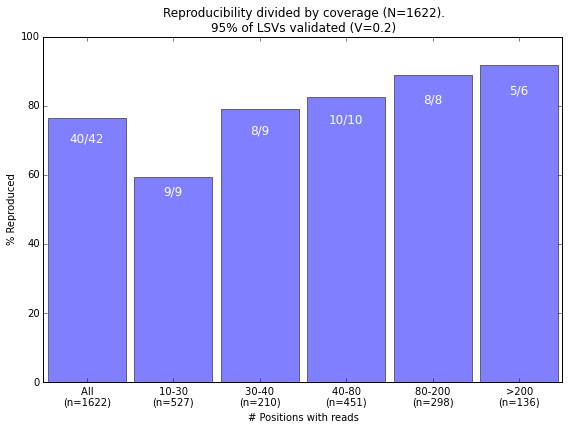

In [14]:
main(args_to_parse='../data/fig2_suppl2/rank_hogen/events.only_exp1.majiq_1.pickle --builder-files ../data/fig2_BC/Hogenesch/clean_reads.Cer_284052.pkl ../data/fig2_BC/Hogenesch/clean_reads.Liv_284052.pkl --V .2 --rtpcr-files ../data/fig2_BC/Hogenesch/Liv_v_Cer_RTPCR_by_replicate_final_with_JUNCTIONS.txt --output plots'.split())